# Method 3: CNN with Multi-Head Attention (Fixed)
## Key Fixes:
- **Data Augmentation** to increase effective training samples
- **Simpler architecture** appropriate for small dataset
- **Label smoothing** to prevent overconfident predictions

In [1]:
import numpy as np
import librosa
import os
import random
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

# Seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Config
SAMPLE_RATE = 22050
DURATION = 30
N_MELS = 64
N_FFT = 2048
HOP_LENGTH = 512
NUM_SEGMENTS = 10
NUM_CLASSES = 10

GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']

DATA_PATH = '/Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/data/gtzan/genres_original'
OUTPUT_DIR = '/Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/output'

print(f'TensorFlow: {tf.__version__}')

TensorFlow: 2.15.0


## Data Augmentation Functions

In [2]:
def augment_audio(y, sr):
    """Apply audio augmentations to increase training data."""
    augmented = [y]  # Original
    
    # Time stretch
    rate = np.random.uniform(0.9, 1.1)
    y_stretch = librosa.effects.time_stretch(y, rate=rate)
    if len(y_stretch) > len(y):
        y_stretch = y_stretch[:len(y)]
    else:
        y_stretch = np.pad(y_stretch, (0, len(y) - len(y_stretch)))
    augmented.append(y_stretch)
    
    # Pitch shift
    n_steps = np.random.randint(-2, 3)
    if n_steps != 0:
        y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
        augmented.append(y_pitch)
    
    # Add noise
    noise = np.random.normal(0, 0.005, len(y))
    augmented.append(y + noise)
    
    return augmented

print('Augmentation functions defined')

Augmentation functions defined


## Feature Extraction with Segmentation

In [3]:
def extract_segmented_melspec(y, sr, num_segments=NUM_SEGMENTS):
    """Extract mel-spectrogram and segment into parts."""
    # Full mel-spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, 
                                          n_fft=N_FFT, hop_length=HOP_LENGTH)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    # Segment into equal parts
    total_frames = mel_db.shape[1]
    segment_len = total_frames // num_segments
    
    segments = []
    for i in range(num_segments):
        start = i * segment_len
        end = start + segment_len
        seg = mel_db[:, start:end]
        segments.append(seg)
    
    return np.array(segments)  # (10, 64, segment_len)

print('Feature extraction defined')

Feature extraction defined


## Load Dataset with Augmentation

In [4]:
def load_dataset(data_path, augment=True):
    """Load GTZAN with optional augmentation."""
    X, y = [], []
    
    for genre in GENRES:
        genre_path = os.path.join(data_path, genre)
        if not os.path.exists(genre_path):
            continue
        
        files = sorted([f for f in os.listdir(genre_path) if f.endswith('.wav')])
        print(f'{genre}: {len(files)} files')
        
        for f in files:
            try:
                filepath = os.path.join(genre_path, f)
                audio, sr = librosa.load(filepath, sr=SAMPLE_RATE, duration=DURATION)
                
                # Pad/trim to exact length
                target_len = SAMPLE_RATE * DURATION
                if len(audio) < target_len:
                    audio = np.pad(audio, (0, target_len - len(audio)))
                else:
                    audio = audio[:target_len]
                
                # Get audio versions (original + augmented)
                if augment:
                    audio_versions = augment_audio(audio, sr)
                else:
                    audio_versions = [audio]
                
                for av in audio_versions:
                    features = extract_segmented_melspec(av, sr)
                    X.append(features)
                    y.append(genre)
                    
            except Exception as e:
                print(f'Error: {f}: {e}')
    
    return np.array(X), np.array(y)

print('Loading dataset with augmentation...')
X, y = load_dataset(DATA_PATH, augment=True)
print(f'\nTotal samples: {len(X)}')
print(f'Shape: {X.shape}')

Loading dataset with augmentation...
blues: 100 files
classical: 100 files
country: 100 files
disco: 100 files
hiphop: 100 files
jazz: 99 files
metal: 100 files
pop: 100 files
reggae: 100 files
rock: 100 files

Total samples: 3796
Shape: (3796, 10, 64, 129)


## Train/Val/Test Split and Normalize

In [5]:
# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Split: 80/10/10
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_enc, test_size=0.1, stratify=y_enc, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111, stratify=y_temp, random_state=SEED)

# Normalize
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / (std + 1e-8)
X_val = (X_val - mean) / (std + 1e-8)
X_test = (X_test - mean) / (std + 1e-8)

# Add channel dim
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# One-hot with label smoothing
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_val_cat = to_categorical(y_val, NUM_CLASSES)
y_test_cat = to_categorical(y_test, NUM_CLASSES)

print(f'Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}')

Train: (3036, 10, 64, 129, 1), Val: (380, 10, 64, 129, 1), Test: (380, 10, 64, 129, 1)


## Multi-Head Attention Layer (Simplified)

In [6]:
class MultiHeadAttention(layers.Layer):
    """Simplified Multi-Head Attention for small datasets."""
    
    def __init__(self, d_model=64, num_heads=4, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.dropout_rate = dropout_rate
        
        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)
        self.dense = layers.Dense(d_model)
        self.dropout = layers.Dropout(dropout_rate)
    
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]
        
        q = self.split_heads(self.wq(inputs), batch_size)
        k = self.split_heads(self.wk(inputs), batch_size)
        v = self.split_heads(self.wv(inputs), batch_size)
        
        scale = tf.math.sqrt(tf.cast(self.depth, tf.float32))
        attention = tf.nn.softmax(tf.matmul(q, k, transpose_b=True) / scale, axis=-1)
        attention = self.dropout(attention, training=training)
        
        out = tf.matmul(attention, v)
        out = tf.transpose(out, perm=[0, 2, 1, 3])
        out = tf.reshape(out, (batch_size, -1, self.d_model))
        
        return self.dense(out)

print('MultiHeadAttention defined: 4 heads, 64 dimensions')

MultiHeadAttention defined: 4 heads, 64 dimensions


## Build Model

In [7]:
def build_segment_cnn(input_shape):
    """CNN for each segment - smaller architecture."""
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(32, (3,3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    return Model(inputs, x, name='segment_cnn')

def build_model(segment_shape):
    """Full model with multi-head attention."""
    inputs = layers.Input(shape=(NUM_SEGMENTS,) + segment_shape)
    
    # CNN per segment
    cnn = build_segment_cnn(segment_shape)
    x = layers.TimeDistributed(cnn)(inputs)  # (batch, 10, 64)
    
    # Multi-head attention
    x = MultiHeadAttention(d_model=64, num_heads=4, dropout_rate=0.2)(x)
    
    # Pool over time
    x = layers.GlobalAveragePooling1D()(x)
    
    # Classifier
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build
segment_shape = X_train.shape[2:]  # (64, seg_len, 1)
model = build_model(segment_shape)
model.summary()

2025-12-05 16:39:23.024015: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-12-05 16:39:23.024077: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-12-05 16:39:23.024091: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2025-12-05 16:39:23.024115: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-05 16:39:23.024127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 64, 129, 1)   0         
                             ]                                   
                                                                 
 time_distributed (TimeDist  (None, 10, 64)            19200     
 ributed)                                                        
                                                                 
 multi_head_attention (Mult  (None, None, 64)          16640     
 iHeadAttention)                                                 
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_4 (Dense)             (None, 64)                4160  

## Train

In [8]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


2025-12-05 16:39:25.310579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-12-05 16:39:25.380176: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_16.


95/95 [==============================] - 15s 135ms/step - loss: 2.3959 - accuracy: 0.1752 - val_loss: 2.2169 - val_accuracy: 0.1947 - lr: 3.0000e-04
Epoch 2/100
95/95 [==============================] - 12s 123ms/step - loss: 2.0471 - accuracy: 0.2487 - val_loss: 1.9987 - val_accuracy: 0.2579 - lr: 3.0000e-04
Epoch 3/100
95/95 [==============================] - 11s 117ms/step - loss: 1.8733 - accuracy: 0.3076 - val_loss: 1.6333 - val_accuracy: 0.3684 - lr: 3.0000e-04
Epoch 4/100
95/95 [==============================] - 11s 118ms/step - loss: 1.7884 - accuracy: 0.3399 - val_loss: 1.6644 - val_accuracy: 0.3737 - lr: 3.0000e-04
Epoch 5/100
95/95 [==============================] - 11s 116ms/step - loss: 1.6964 - accuracy: 0.3758 - val_loss: 1.4840 - val_accuracy: 0.4816 - lr: 3.0000e-04
Epoch 6/100
95/95 [==============================] - 11s 115ms/step - loss: 1.6228 - accuracy: 0.4048 - val_loss: 1.3835 - val_accuracy: 0.5211 - lr: 3.0000e-04
Epoch 7/100
95/95 [===========================

## Results

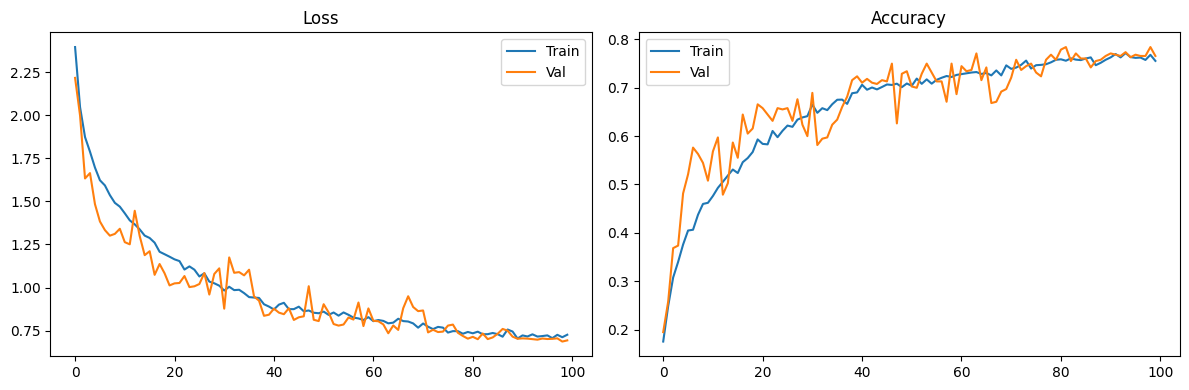

12/12 [==============================] - 1s 29ms/step

Test Accuracy: 78.42%

Classification Report:
              precision    recall  f1-score   support

       blues       0.75      0.87      0.80        38
   classical       0.85      0.92      0.89        38
     country       0.59      0.58      0.59        38
       disco       0.74      0.68      0.70        37
      hiphop       0.85      0.89      0.87        38
        jazz       0.89      0.82      0.85        39
       metal       0.89      0.82      0.85        38
         pop       0.84      0.84      0.84        38
      reggae       0.89      0.84      0.86        38
        rock       0.56      0.58      0.57        38

    accuracy                           0.78       380
   macro avg       0.79      0.78      0.78       380
weighted avg       0.79      0.78      0.78       380



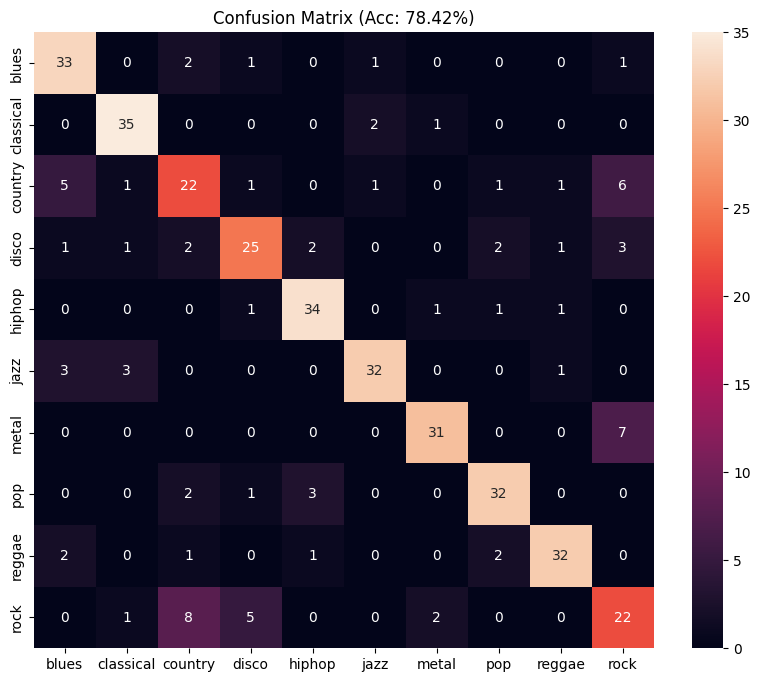

In [9]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Val')
ax1.set_title('Loss'); ax1.legend()
ax2.plot(history.history['accuracy'], label='Train')
ax2.plot(history.history['val_accuracy'], label='Val')
ax2.set_title('Accuracy'); ax2.legend()
plt.tight_layout()
plt.show()

# Evaluate
y_pred = np.argmax(model.predict(X_test), axis=1)
acc = accuracy_score(y_test, y_pred)
print(f'\nTest Accuracy: {acc:.2%}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=GENRES))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=GENRES, yticklabels=GENRES)
plt.title(f'Confusion Matrix (Acc: {acc:.2%})')
plt.show()